In [2]:
%matplotlib notebook
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

$[E_f, E_b]^T = I_{\text{vac}, n} L_n I_{n-1} L_{n-1} \cdots I_1 L_1 I_{\text{sub}} [E_s, 0]^T$

So, for every layer we just need to define a vacuum interface matrix $I_{\text{vac},n}$, a layer matrix $L_n(t)$, and a transfer matrix $T_n = I_{n-1} L_{n-1} \cdots I_1 L_1 I_{\text{sub}}$

Note that $T_n = I_{n-1} L_{n-1}(t_f) T_{n-1}$

Reflectance should be $E_f = M_{00} E_s$ and $E_b = M_{10} E_s$ so $r = M_{10}/M_{00}$

In [3]:
class Material():
    def __init__(self, name):
        self.name = name
        self.N = {}
        
    def set_N_at_wavelength(self, wavelength, N):
        self.N[str(wavelength)] = N

class Layer():
    def __init__(self, material, thickness, growth_rate, previous_layer):
        self.thickness = thickness
        self.material = material
        self.N = self.material.N
        self.growth_rate = growth_rate
        self.previous_layer = previous_layer
        
        self.growth_time = thickness/growth_rate
        
    def set_transfer_matrix(self, transfer_matrix):
        self.transfer_matrix = transfer_matrix
        
    def set_vacuum_interface_matrix(self, vacuum_interface_matrix):
        self.vacuum_interface_matrix = vacuum_interface_matrix
        
    def set_layer_matrix(self, layer_matrix, t):
        self.layer_matrix = layer_matrix
        self.t = t
        
    def set_reflectance(self, reflectance):
        self.reflectance = reflectance

        
class Structure():
    def __init__(self, substrate_material, num_t = 1000):
        self.substrate_material = substrate_material
        self.num_t = num_t
        self.layers = []
        
        self.wavelength_scale = 1.0 # Assumes wavelengths and structure are both in nm
        # To change structure to angstrom, use use_angstroms_for_structure()
    
    def use_angstroms_for_structure(self):
        self.wavelength_scale = 0.1
    
    def set_wavelength(self, wavelength):
        self.wavelength = str(wavelength)
        
    def add_layer(self, material, thickness, growth_rate):
        if not self.layers:
            self.layers.append(Layer(material, 
                                     thickness, 
                                     growth_rate, 
                                     self.substrate_material))
        else:
            self.layers.append(Layer(material, 
                                     thickness, 
                                     growth_rate, 
                                     self.layers[-1].material))
            
    def calculate_transfer_matrices(self):
        
      
        for i in range(len(self.layers)):
            
            Ni = self.layers[i].material.N[self.wavelength]
            if i != 0:
                Nim1 = self.layers[i-1].material.N[self.wavelength]
            
            # Transfer matrices
            if i == 0:
                T0 = np.zeros((2,2), dtype = complex)
                T0[0,0] = Ni + self.substrate_material.N[self.wavelength]
                T0[0,1] = Ni - self.substrate_material.N[self.wavelength]
                T0[1,0] = T0[0,1]
                T0[1,1] = T0[0,0]

                T0 /= 2*Ni

                self.layers[0].set_transfer_matrix(T0)
                
            else:
                
                T = np.matmul(self.layers[i-1].layer_matrix[-1,:,:], 
                              self.layers[i-1].transfer_matrix)
                
                I = np.zeros((2,2), dtype = complex)
                I[0,0] = Ni + Nim1
                I[0,1] = Ni - Nim1
                I[1,0] = I[0,1]
                I[1,1] = I[0,0]
                
                I /= 2*Ni
                
                T = np.matmul(I, T)
                
                self.layers[i].set_transfer_matrix(T)
                
            # Vacuum interface matrices
            I = np.zeros((2,2), dtype = complex)
            I[0,0] = 1.0 + Ni
            I[0,1] = 1.0 - Ni
            I[1,0] = I[0,1]
            I[1,1] = I[0,0]

            I /= 2
            
            self.layers[i].set_vacuum_interface_matrix(I)
            
            # Layer matrices                                 

            d = np.linspace(0, self.layers[i].thickness, self.num_t)
            
            t = d/self.layers[i].growth_rate
            
            if i != 0:
                t += self.layers[i-1].t[-1]
            
            wl = float(self.wavelength)/self.wavelength_scale

            exp_fact = np.exp(1j*2*np.pi*Ni*d/wl)
            
            L = np.zeros((self.num_t,2,2), dtype = complex)
            
            L[:,0,0] = exp_fact
            L[:,0,1] = 0.0 + 1j*0
            L[:,1,0] = 0.0 + 1j*0
            L[:,1,1] = 1/exp_fact
            
            self.layers[i].set_layer_matrix(L,t)
    
    def calculate_reflectance(self, wavelength):
        
        self.set_wavelength(wavelength)
        
        self.calculate_transfer_matrices()
        
        t_total = np.array([])
        R_total = np.array([])
        
        for layer in self.layers:
            M = np.zeros((self.num_t,2,2), dtype = complex)
            
            M = np.matmul(layer.layer_matrix, layer.transfer_matrix)
            M = np.matmul(layer.vacuum_interface_matrix, M)
            
            r = M[:,1,0]/M[:,0,0]
            
            R = np.abs(r)**2
            
            layer.set_reflectance(R)
        
            t_total = np.concatenate((t_total, layer.t))
            R_total = np.concatenate((R_total, layer.reflectance))
            
        return t_total, R_total

In [5]:
# Set up materials

GaAs = Material('GaAs')
AlAs = Material('AlAs')

GaAs.set_N_at_wavelength(950.3, 3.7575 - 1j*0.1070)
AlAs.set_N_at_wavelength(950.3, 3.047 - 1j*0.00)

GaAs.set_N_at_wavelength(469.5, 4.667 - 1j*1.594)
AlAs.set_N_at_wavelength(469.5, 3.7341 - 1j*0.1022)


<IPython.core.display.Javascript object>


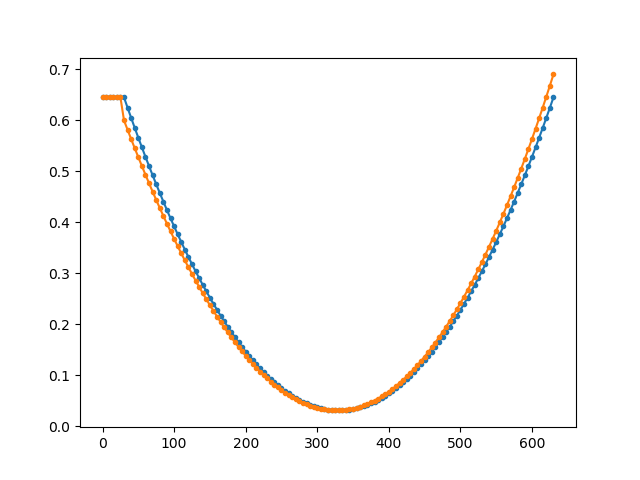

In [118]:
G_max = 0.6447
G_min = 0.0307

t_QW = 600
t_barrier = 30

dt = 5

t_period = t_QW + t_barrier
t_max = N_period*t_period

N_t = int(t_max/dt) + 1

t = np.linspace(0, t_max, N_t)

dt = t[1] - t[0]

G = np.ones_like(t)*G_max

t_shift = t - t_barrier - t_QW/2

t_rel = t_shift/(t_QW/2)

mask = (t_shift >= -t_QW/2) & (t_shift <= t_QW/2)

G[mask] = (G_max - G_min)*(t_rel[mask])**2 + G_min

G_pert = np.copy(G)
G_pert[mask] += 0.02*G_max*t_rel[mask] + 0.05*G_max*t_rel[mask]**3 #+ 0.005*G_max
    
fig, ax = plt.subplots()
ax.plot(t, G, '.-')

ax.plot(t, G_pert, '.-')

t_G = np.copy(t)

In [119]:
#### Define structure ####

num_repeats = 3

struct = Structure(substrate_material = GaAs)
struct_pert = Structure(substrate_material = GaAs)

t_buffer = 100
struct.add_layer(AlAs, G_max*t_buffer, G_max)
struct_pert.add_layer(AlAs, G_max*t_buffer, G_max)
for j in range(num_repeats):
    for i in range(N_t):
        struct.add_layer(AlAs, G[i]*dt, G[i])
        struct_pert.add_layer(AlAs, G_pert[i]*dt, G_pert[i])
    
#### Calculate reflectance ####
t = {}
R = {}

t_pert = {}
R_pert = {}

wavelengths = [950.3, 469.5]

for wl in wavelengths:
    t[str(wl)], R[str(wl)] = struct.calculate_reflectance(wavelength = wl)
    t_pert[str(wl)], R_pert[str(wl)] = struct_pert.calculate_reflectance(wavelength = wl)



<IPython.core.display.Javascript object>


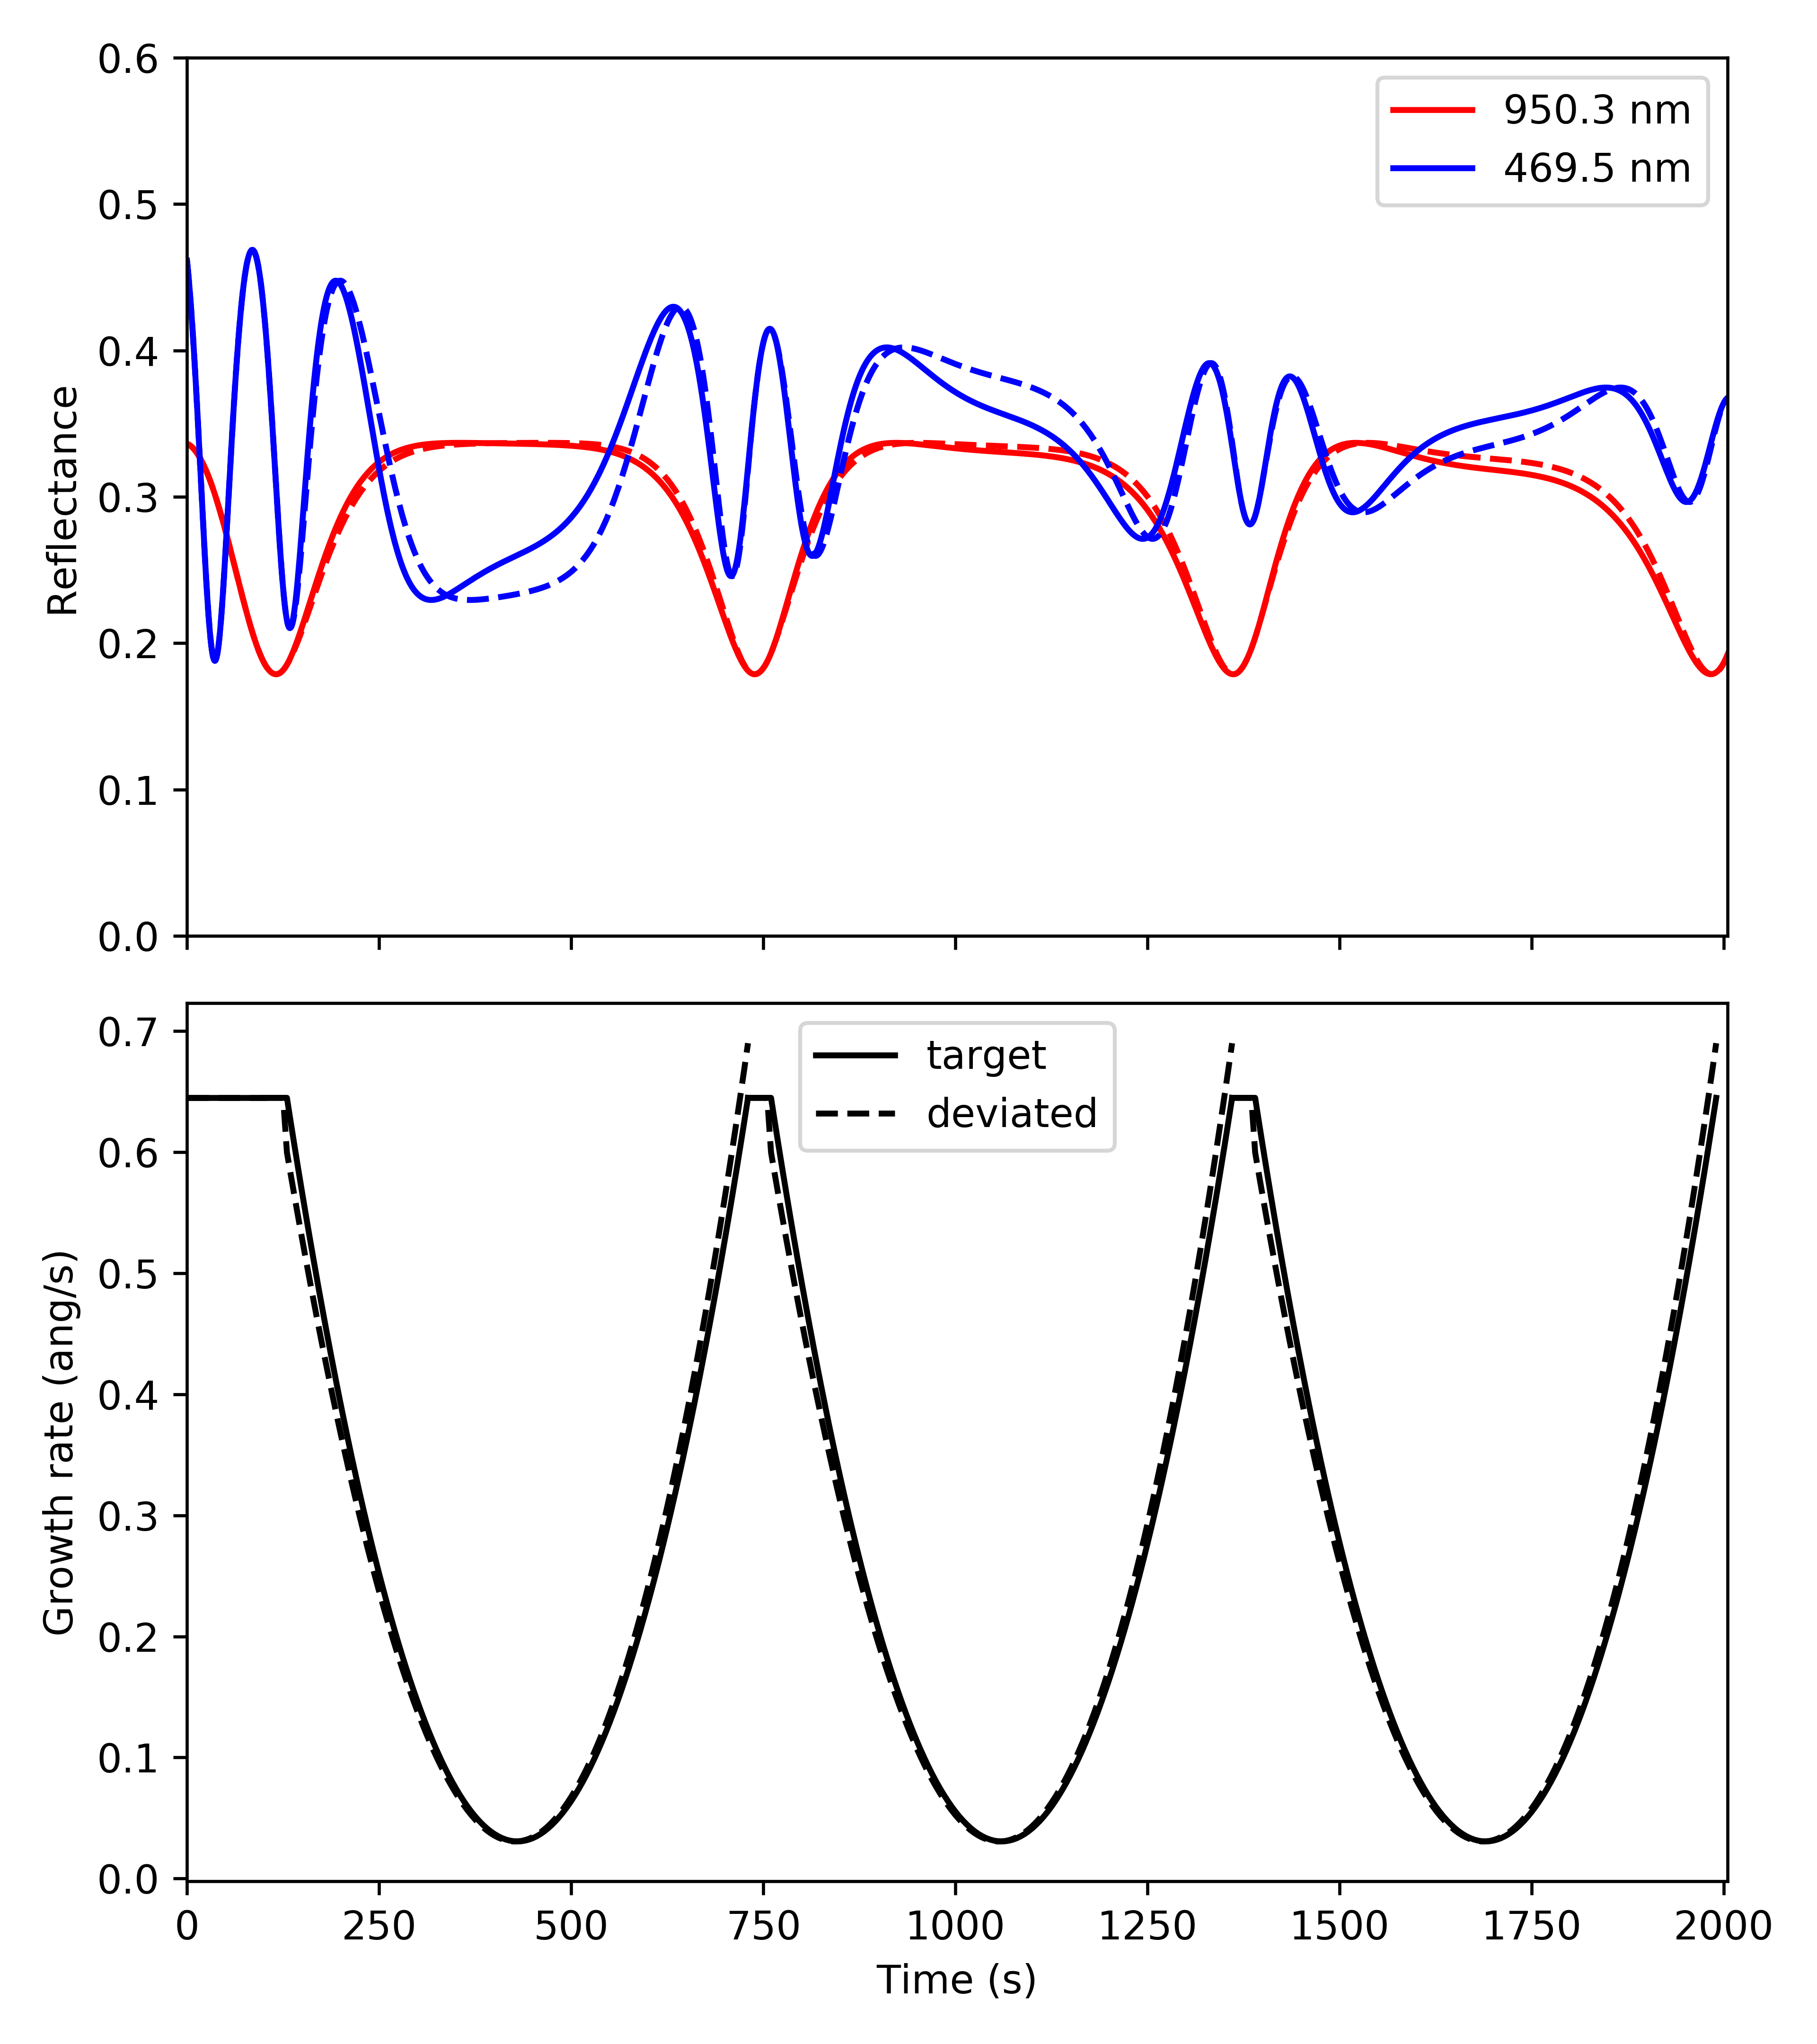

In [122]:
#### Plot reflectance ####

fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [6.4,4.8*1.5], dpi = 600)

colors = {'950.3': 'r', '469.5': 'b'}
for wavelength in wavelengths:
    wl = str(wavelength)
    ax[0].plot(t[wl], R[wl], label = wl + ' nm', color = colors[wl])
    ax[0].plot(t_pert[wl], R_pert[wl], '--', color = colors[wl])
    
    
ax[0].legend()

ax[0].set_ylabel('Reflectance')
ax[0].set_ylim([0,0.6])
ax[0].set_xlim([0,t[wl][-1]])

for i in range(num_repeats):
    ax[1].plot(t_G + i*t_period + t_buffer, G, '-k')
    ax[1].plot(t_G + i*t_period + t_buffer, G_pert, '--k')
    
ax[1].plot([0,t_buffer], [G_max, G_max], '-k', label = 'target')
ax[1].plot([0,t_buffer], [G_max, G_max], '--k', label = 'deviated')
#ax[1].plot(t_G, np.cumsum(G)*dt, '-k', label = 'target')
#ax[1].plot(t_G, np.cumsum(G_pert)*dt, '--k', label = 'deviated')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Growth rate (ang/s)')
ax[1].legend()
#ax[1].set_ylabel('Thickness (ang)')

plt.tight_layout()

### Structure design

AlAs thickness: 2339.10 Angstrom
GaAs thickness: 3161.34 Angstrom

Alternate between AlAs and GaAs